# NicheVI for representing cells and their environment in spatial transcriptomics
In this tutorial, we go through the steps of training NicheVI, a deep generative model that leverages both cell-intrinsic and neighboring gene expression profiles to produce stochastic embeddings of cell states as well as normalized gene expression profiles. We show how to obtain informative fine-grained partitions of cells that reflects both their internal state and the surrounding tissue and use the generative model to test hypotheses of differential expression between tissue niches.

Plan for this tutorial:

1. Loading the data
2. Training a NicheVI model
3. Visualizing the latent space
4. Perform DE analysis across niches

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Install from GitHub for now
!pip install --quiet scvi-colab
!pip install --quiet adjustText
from scvi_colab import install

install()

/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [3]:
import os
import tempfile

import numpy as np  # type: ignore
import scanpy as sc  # type: ignore
import scvi  # type: ignore
from rich import print  # type: ignore

sc.set_figure_params(figsize=(4, 4))
save_dir = tempfile.TemporaryDirectory()
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Impor

Last run with scvi-tools version: 1.3.0

In [4]:
# Quickly check the correct folder is used.
scvi.__file__

'/home/nathanl/scvi-tools-main/src/scvi/__init__.py'

## Data loading

In this tutorial we load a human breast cancer section, generated with [10X Xenium](https://www.nature.com/articles/s41467-023-43458-x). 
The cell segmentation originally performed on this data resulted in many erroneously assigned transcripts and therefore re-segmented the cells using the [ProSeg](https://www.biorxiv.org/content/10.1101/2024.04.25.591218v1) algorithm, which is a scalable algorithm for transcriptome-informed segmentation.

In [5]:
adata_path = os.path.join(save_dir.name, "xenium_tutorial.h5ad")
adata = sc.read(
    adata_path,
    backup_url="https://figshare.com/ndownloader/files/53178338",
)
adata

  0%|          | 0.00/1.11G [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 117305 × 313
    obs: 'sample', 'x', 'y', 'z', 'observed_x', 'observed_y', 'observed_z', 'fov', 'n_counts', 'index', 'cell_type'
    var: 'mt'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'pca'
    obsm: 'X_pca', 'X_scANVI', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'counts_log1p', 'counts_wo_bg', 'min_max_scaled', 'min_max_scaled_raw'

The authors identified distinct tumor domains in this specimen, corresponding to in situ ductal carcinoma (DCIS) and invasive tumor:

[autoreload of scvi.external.nichevi.differential_expression._results_dataclass failed: Traceback (most recent call last):
  File "/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/nathanl/miniforge3/envs/scvi/lib/python3.12/importlib/__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 995, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/home/nathanl/scvi-tools-main/src/scvi/external/nichevi/differential_expression/_results_dataclass.py", line 11, in <module>
    class DifferentialExpressionResu

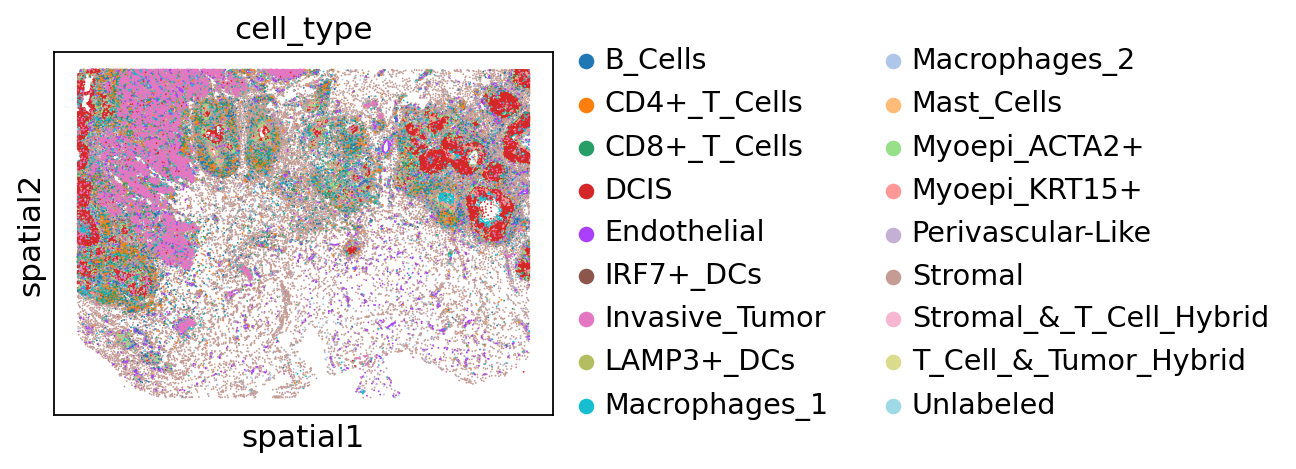

In [6]:
sc.pl.spatial(adata, color="cell_type", spot_size=30)

In [7]:
adata.obs["cell_type"].value_counts()

cell_type
Stromal                    32426
Invasive_Tumor             18185
DCIS                       15993
CD4+_T_Cells                9387
Macrophages_1               8644
CD8+_T_Cells                7493
Endothelial                 7000
B_Cells                     5359
Myoepi_ACTA2+               5324
Myoepi_KRT15+               2636
Macrophages_2               2616
Perivascular-Like            817
Unlabeled                    516
IRF7+_DCs                    454
LAMP3+_DCs                   218
Mast_Cells                   203
Stromal_&_T_Cell_Hybrid       28
T_Cell_&_Tumor_Hybrid          6
Name: count, dtype: int64

## Train NicheVI model

We first define the neighborhood of each cell using a k-nn graph. We set $k=20$. Then, the environment features are defined in two ways - the first is the cell-type composition of its cellular neighborhood. The second is the average gene expression state of neighboring cells, with a separate profile for each of the present cell types. These cell-intrinsic gene expression states are learned with a spatially unaware model, which needs to be trained first.

Here we assume that scANVI has already been trained on the data, and that the embeddings are stored in the AnnData object. We refer to the scANVI tutorial for training the model.


Environment features computations occur in the `preprocessing_anndata` method, that adds the relevant keys to the AnnData object. 

In [8]:
setup_kwargs = {
    "sample_key": "sample",  # specify column in adata.obs that contains the individual slide ID
    "labels_key": "cell_type",  # specify column in adata.obs that contains the cell type labels
    "cell_coordinates_key": "spatial",  # specify key in adata.obsm that contains the spatial coordinates
    "expression_embedding_key": "X_scANVI",  # specify key in adata.obsm that contains the expression embedding
}

In [9]:
scvi.external.nicheSCVI.preprocessing_anndata(
    adata,
    k_nn=20,  # number of nearest neighbors for spatial graph construction
    **setup_kwargs,
)

Saved niche_indexes and niche_distances in adata.obsm

Saved niche_composition in adata.obsm

Saved niche_activation in adata.obsm

Then, as in all scvi-tools model, we need to register the AnnData.

In [10]:
scvi.external.nicheSCVI.setup_anndata(
    adata,
    layer="counts",  # specify layer in adata that contains the raw counts
    batch_key="sample",  # specify column in adata.obs that contains the batch covariate to correct for
    **setup_kwargs,
)

INFO     Using column names from columns of adata.obsm['niche_composition']                                        


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


We instantiate a NicheVI model:

In [11]:
nichevae = scvi.external.nicheSCVI(adata)

nichevae

nicheVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [12]:
nichevae.train(
    max_epochs=200,
    early_stopping=True,
    check_val_every_n_epoch=1,
    batch_size=512,
    plan_kwargs={
        "lr": 5e-4,
    },
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottlen

Training:   0%|          | 0/200 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


We can plot the training curves:

In [13]:
nichevae.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'niche_compo_validation', 'niche_reconst_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'niche_compo_train', 'niche_reconst_train'])

Let's plot for instance the validation ELBO, niche composition and state losses:

<Axes: xlabel='epoch'>

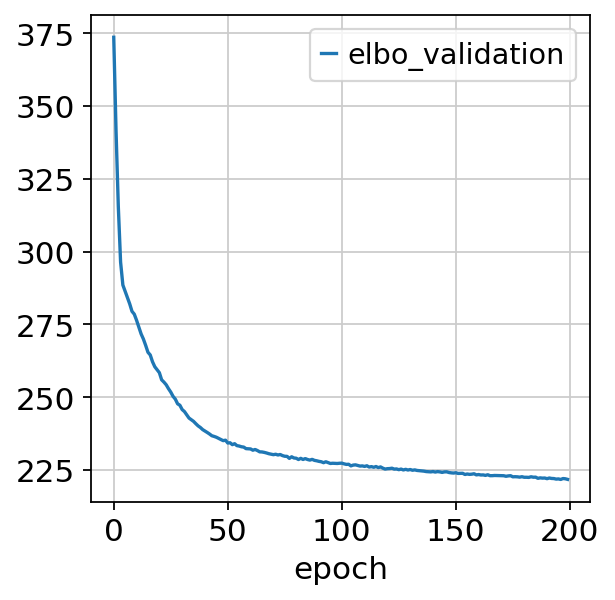

In [14]:
nichevae.history["elbo_validation"].plot()

<Axes: xlabel='epoch'>

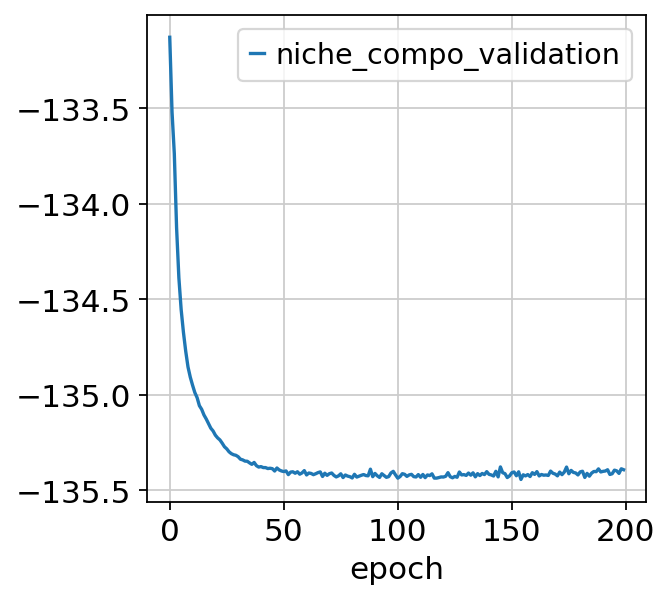

In [15]:
nichevae.history["niche_compo_validation"].plot()

<Axes: xlabel='epoch'>

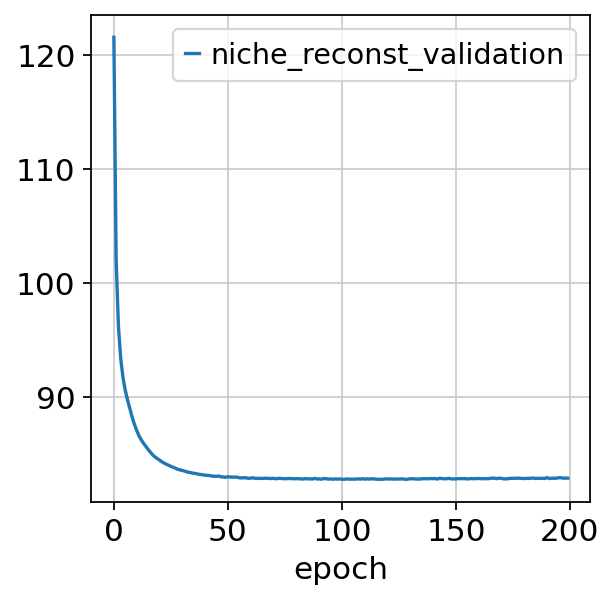

In [16]:
nichevae.history["niche_reconst_validation"].plot()

After training the model, we can compute and store the latent space: 

In [17]:
adata.obsm["X_nicheVI"] = nichevae.get_latent_representation()

We may visualize the latent space in UMAP coordinates, coloring by cell type. 

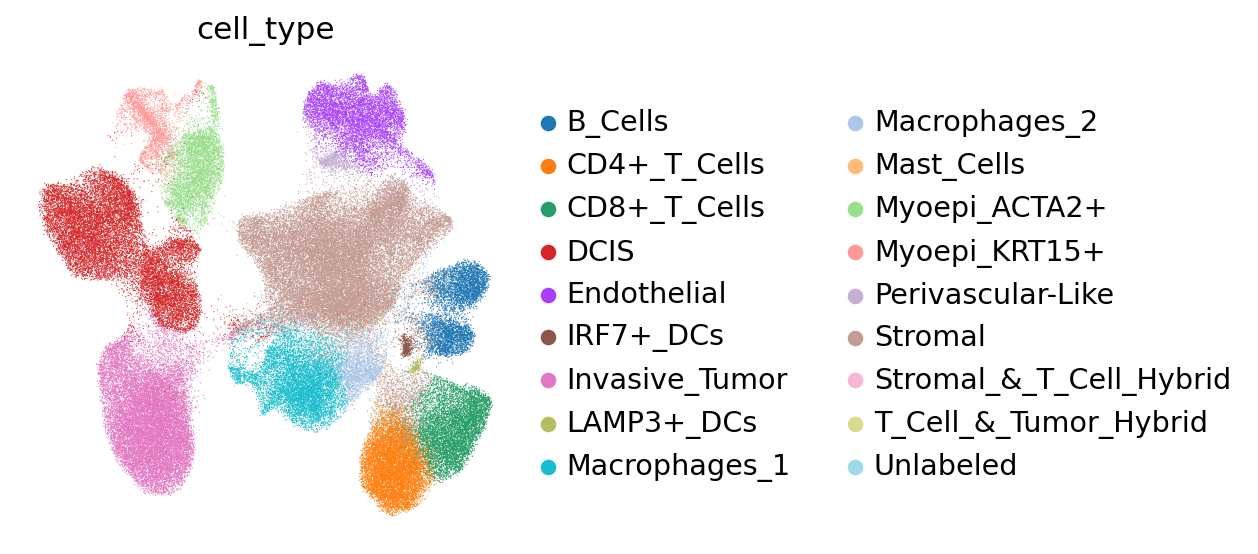

In [18]:
sc.pp.neighbors(adata, use_rep="X_nicheVI", n_neighbors=30)
sc.tl.umap(adata)

sc.pl.umap(adata, color="cell_type", frameon=False)

# Differential expression analysis

We now use the generative model to test hypotheses of differential expression between the niches. We'll focus on endothelial cells. 

In [19]:
adata_endothelial = adata[adata.obs["cell_type"] == "Endothelial"].copy()
adata_not_endo = adata[adata.obs["cell_type"] != "Endothelial"].copy()

print(adata_endothelial)

AnnData object with n_obs × n_vars = 7000 × 313
    obs: 'sample', 'x', 'y', 'z', 'observed_x', 'observed_y', 'observed_z', 'fov', 'n_counts', 'index', 
'cell_type', '_scvi_batch', '_scvi_labels', '_scvi_sample'
    var: 'mt'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'pca', 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_scANVI', 'spatial', 'niche_indexes', 'niche_distances', 'niche_composition', 
'niche_activation', 'X_nicheVI', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'counts_log1p', 'counts_wo_bg', 'min_max_scaled', 'min_max_scaled_raw'
    obsp: 'distances', 'connectivities'

We perform coarse Leiden clustering on the endothelial latent space, in a bid to find spatially confined populations of endothelial cells.

In [20]:
sc.pp.neighbors(adata_endothelial, use_rep="X_nicheVI", n_neighbors=30, random_state=42)
sc.tl.umap(adata_endothelial)
sc.tl.leiden(
    adata_endothelial,
    key_added="leiden_nicheVI",
    resolution=0.3,
    flavor="igraph",
    n_iterations=-1,
    random_state=42,
)

In [21]:
adata_endothelial.obs["leiden_nicheVI"].unique()  # check the number of clusters

['0', '1', '4', '3', '2']
Categories (5, object): ['0', '1', '2', '3', '4']

We focus on clusters 0 and 1, which are located in the stromal and tumor regions, respectively. We then perform differential expression analysis between these two clusters.

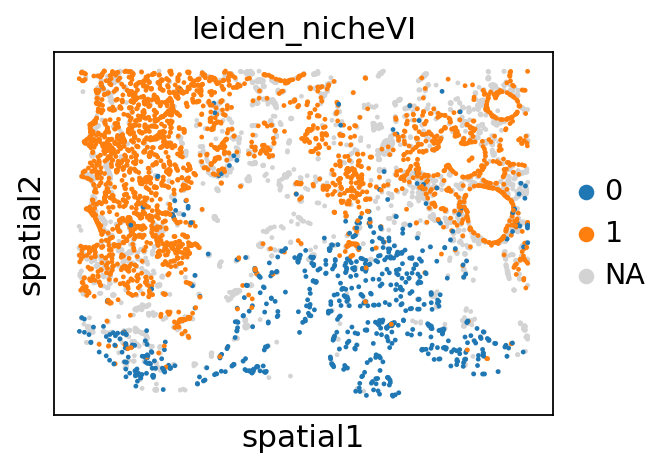

In [22]:
sc.pl.spatial(
    adata_endothelial,
    color="leiden_nicheVI",
    spot_size=80,
    groups=["1", "0"],
)

In [23]:
adata.obs["leiden_nicheVI"] = "Unknown"
adata.obs.loc[adata.obs["cell_type"] == "Endothelial", "leiden_nicheVI"] = adata_endothelial.obs[
    "leiden_nicheVI"
]

In [24]:
adata.obs["leiden_nicheVI"].value_counts()

leiden_nicheVI
Unknown    110305
1            2818
3            1708
2            1482
0             713
4             279
Name: count, dtype: int64

We now run the differential expression function, between the nichetypes $\textit{G1}=tumor~endothelial$ and $\textit{G2}=stromal~endothelial$. We first set the number of nearest neighbors to compute the non-endothelial neighbors of $\textit{G1}$ and $\textit{G2}$, called $\textit{N1}$ and $\textit{N2}$, respectively. 

Setting `niche_mode=True`, we compute 4 different DE tests:  $\{\textit{G1}~vs~\textit{G2}\}$,  $\{\textit{G1}~vs~\textit{N1}\}$,  $\{\textit{N1}~vs~\textit{G2}\}$ and $\{\textit{N1}~vs~\textit{N2}\}$ (in this order). We set a test-specific treshold for significant log-fold change `DELTA`. 

Other parameters include the number of samples to draw from the posterior `N_SAMPLES_DE`, `PSEUDOCOUNTS` for stability and `FDR` for the FDR correction. More details can be found in Boyeau et al. PNAS 2023.




In [40]:
delta_niches = 0.05  # smaller delta for niche comparison
delta_markers = 0.15  # bigger delta for G1-N1 comparison
DELTA = [delta_niches, delta_markers, delta_niches, delta_niches]


K_NN_DE = 6

GROUP = "leiden_nicheVI"
G1 = "1"
G2 = "0"
PSEUDOCOUNTS = 1e-4
N_SAMPLES_DE = 1e5
FDR = 0.2

DE_1_0 = nichevae.differential_expression(
    adata,
    groupby=GROUP,
    group1=G1,
    group2=G2,
    k_nn=K_NN_DE,
    delta=DELTA,
    niche_mode=True,
    n_samples_overall=N_SAMPLES_DE,
    fdr_target=FDR,
    pseudocounts=PSEUDOCOUNTS,
)

Computing DE...

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

Running DE for group1_group2

100%|██████████| 1/1 [00:00<00:00, 460.05it/s]


Running DE for group1_neighbors1

100%|██████████| 1/1 [00:00<00:00, 627.89it/s]


Running DE for neighbors1_group2

100%|██████████| 1/1 [00:00<00:00, 440.58it/s]


Running DE for neighbors1_neighbors2

100%|██████████| 1/1 [00:00<00:00, 639.47it/s]


Computing g1 confidence scores...

/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 10.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Let's analysize the DE test: $\textit{G1}=tumor~endothelial$ vs $\textit{G2}=stromal~endothelial$. The DE function returns a Dataclass object `DE_1_0`. 

We can access the Gaussian process classifier properties with the `gpc` attribute: 

In [26]:
DE_1_0.gpc

GaussianProcessClassifier(kernel=1**2 * RationalQuadratic(alpha=0.1, length_scale=10),
                          n_restarts_optimizer=10, random_state=0)

In [27]:
DE_1_0.gpc_info()

Training score:  0.9295774647887324

Marginal likelihood:  -27.973635612415574

Kernel:  31.6**2 * RationalQuadratic(alpha=1, length_scale=10)

The $\textit{G1}$ vs $\textit{G2}$ differential expression results are stored in the `g1_g2` attribute: 

In [28]:
DE_1_0.g1_g2

proba_de  proba_not_de  bayes_factor    scale1    scale2   
VOPP1      0.99105       0.00895      4.707110  0.005949  0.003144  \
ADH1B      0.98965       0.01035     -4.560364  0.000856  0.020523   
ESM1       0.98849       0.01151      4.452961  0.006555  0.000212   
CTSG       0.98191       0.01809     -3.994140  0.000101  0.000517   
PDCD1      0.97391       0.02609     -3.619766  0.000042  0.000116   
...            ...           ...           ...       ...       ...   
BACE2      0.48324       0.51676     -0.067065  0.004386  0.004247   
ACTG2      0.47753       0.52247      0.089941  0.007749  0.007526   
TMEM147    0.47581       0.52419     -0.096836  0.003974  0.003862   
SLC25A37   0.45515       0.54485      0.179883  0.001099  0.001104   
APOBEC3A   0.43351       0.56649      0.267545  0.000087  0.000084   

          pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean2   
VOPP1           0.0001   0.05  0.942419    0.940852  0.378652  ...   0.833100  \
ADH1B           0.0001   0.05 -4.469724   -4.488616  1.957352  ...  10.395512   
ESM1            0.0001   0.05  4.678574    4.778537  1.934166  ...   0.060309   
CTSG            0.0001   0.05 -2.146754   -2.130708  1.032181  ...   0.093969   
PDCD1           0.0001   0.05 -1.454751   -1.464450  0.668026  ...   0.009818   
...                ...    ...       ...         ...       ...  ...        ...   
BACE2           0.0001   0.05  0.022930    0.016656  0.808740  ...   1.058906   
ACTG2           0.0001   0.05  0.001530   -0.020509  0.530605  ...   1.969144   
TMEM147         0.0001   0.05  0.029371    0.035549  0.266821  ...   0.981767   
SLC25A37        0.0001   0.05 -0.015109   -0.018659  0.365206  ...   0.262272   
APOBEC3A        0.0001   0.05  0.005091   -0.015841  0.578727  ...   0.012623   

          non_zeros_proportion1  non_zeros_proportion2  raw_normalized_mean1   
VOPP1                  0.587651               0.464236             64.458512  \
ADH1B                  0.040454               0.572230              3.405375   
ESM1                   0.389283               0.049088            105.334614   
CTSG                   0.006742               0.042076              0.399397   
PDCD1                  0.002129               0.005610              0.197275   
...                         ...                    ...                   ...   
BACE2                  0.461675               0.483871             46.505876   
ACTG2                  0.554649               0.572230             81.622715   
TMEM147                0.489354               0.502104             43.729001   
SLC25A37               0.196593               0.182328             12.976086   
APOBEC3A               0.006388               0.009818              0.512121   

          raw_normalized_mean2  is_de_fdr_0.2  comparison  group1  group2   
VOPP1                31.276018           True      1 vs 0       1       0  \
ADH1B               290.694560           True      1 vs 0       1       0   
ESM1                  3.014233           True      1 vs 0       1       0   
CTSG                  3.393627           True      1 vs 0       1       0   
PDCD1                 0.425320           True      1 vs 0       1       0   
...                        ...            ...         ...     ...     ...   
BACE2                40.307599          False      1 vs 0       1       0   
ACTG2                66.156536          False      1 vs 0       1       0   
TMEM147              35.104757          False      1 vs 0       1       0   
SLC25A37             10.319198          False      1 vs 0       1       0   
APOBEC3A              0.664105          False      1 vs 0       1       0   

         proba_de_g1_n1  
VOPP1          0.106642  
ADH1B          0.000000  
ESM1           0.987492  
CTSG           0.000000  
PDCD1          0.000000  
...                 ...  
BACE2          0.977213  
ACTG2          0.000000  
TMEM147        0.040621  
SLC25A37       0.000000  
APOBEC3A       0.000000 

Where the probability of true DE according to the Gaussian process classifier is stored in the `proba_de_g1_n1` column:

In [29]:
DE_1_0.g1_g2["proba_de_g1_n1"]

VOPP1       0.106642
ADH1B       0.000000
ESM1        0.987492
CTSG        0.000000
PDCD1       0.000000
              ...   
BACE2       0.977213
ACTG2       0.000000
TMEM147     0.040621
SLC25A37    0.000000
APOBEC3A    0.000000
Name: proba_de_g1_n1, Length: 313, dtype: float64

We may also access the other tests results in the same way: `DE_1_0.g1_n1`, `DE_1_0.n1_g2` and `DE_1_0.n1_n2`.

We can then filter genes to upregulated genes, i.e. such that the median Log-Fold Change over the samples is positive, and the `proba_de` (ratio of LFC greater than the defined delta treshold over the total number of posterior samples) is greater than a given filter - here we set it to 0.85.

In [44]:
PROBA_TRES = 0.85

g1_g3_genes = DE_1_0.g1_g2[
    (DE_1_0.g1_g2["lfc_median"] > 0) & (DE_1_0.g1_g2["proba_de"] > PROBA_TRES)
].index

We then display the results: median Log-Fold Change (LFC) of upregulated genes in $\textit{G1}$ vs $\textit{G2}$ displayed on x-axis, while we compare differential expression computed between $\textit{N1}$  and $\textit{G2}$ on the y-axis. 

Genes are colored by their marker label (yellow=significantly upregulated in $\textit{G1}$ vs $\textit{N1}$, green otherwise).

We also display the classifier decision boundary (the predicted probability of being in the yellow class). 

/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names
  warnings.warn(


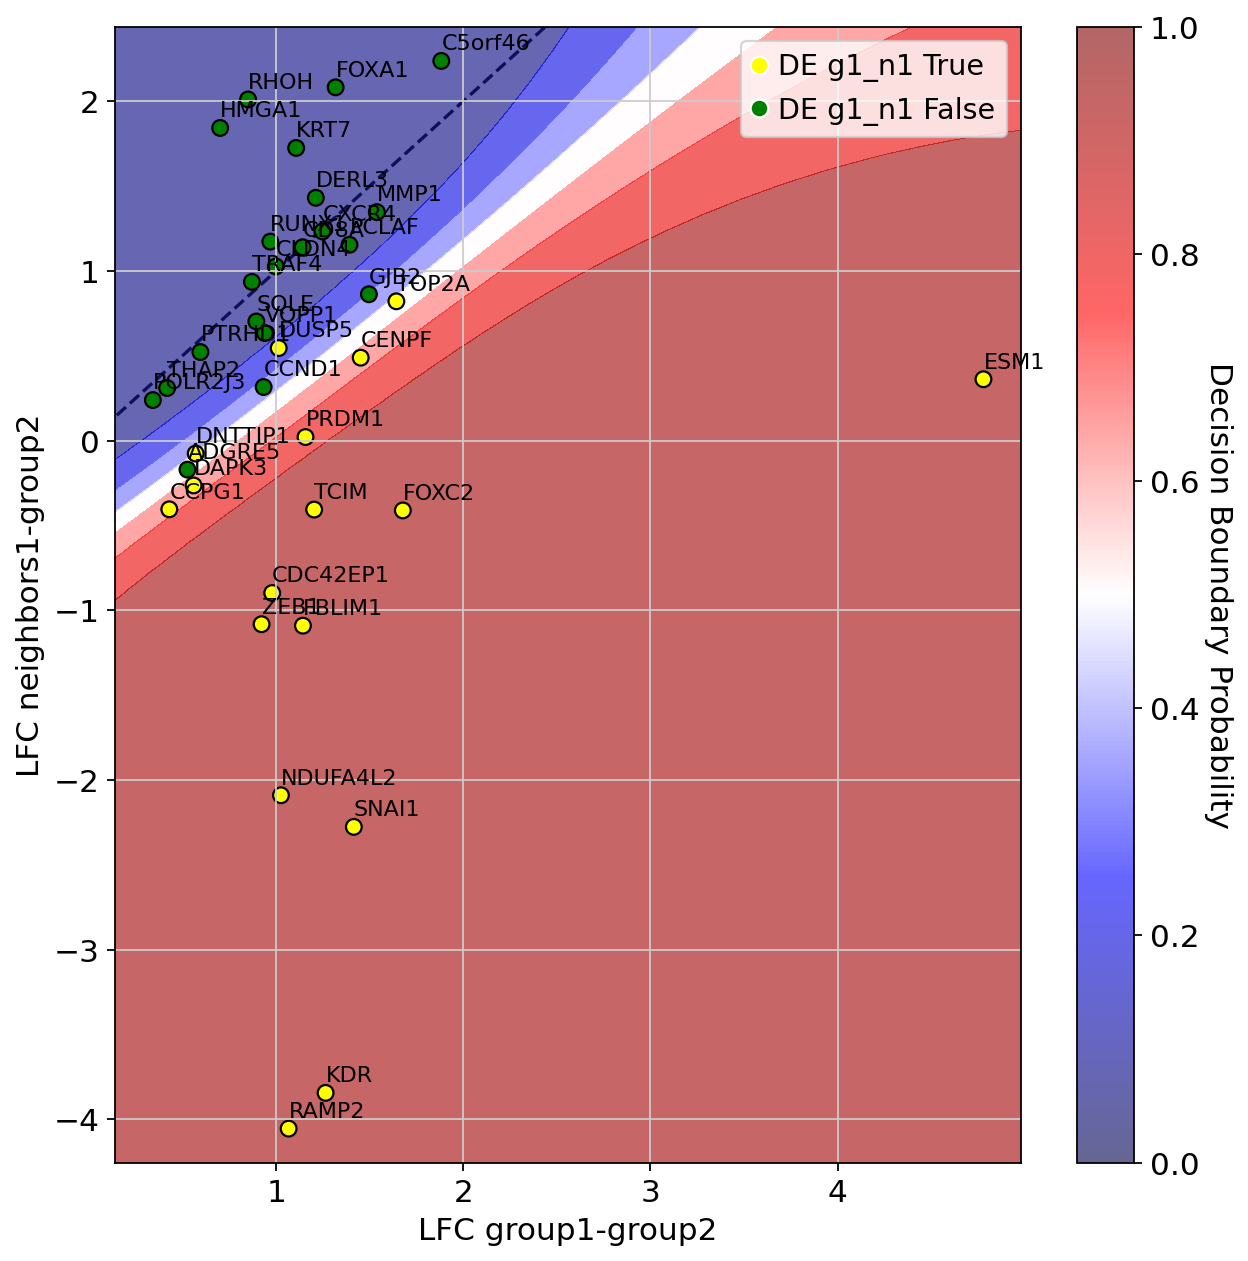

In [45]:
PLOT_MARGIN = 0.2

DE_1_0.plot(
    filter=g1_g3_genes,  # selected genes to plot
    # path_to_save="DE_plot.svg",
    margin=PLOT_MARGIN,  # margin around the plot
    legend_loc="upper right",  # location of the legend
)

You can select the marker genes (positive class for the classifier, yellow in the plot):

In [33]:
DE_1_0.gpc.confident_genes

Index(['ESM1', 'DNTTIP1', 'TCIM', 'PRDM1', 'TOP2A', 'CENPF', 'FOXC2', 'ZEB1',
       'CDC42EP1', 'DUSP5', 'SNAI1', 'KDR', 'FBLIM1', 'CCPG1', 'NDUFA4L2',
       'DAPK3', 'RAMP2'],
      dtype='object')

We can also check the predicted class probabilities of the Gaussian process classifier:

In [34]:
DE_1_0.g1_g2["proba_de_g1_n1"].loc[DE_1_0.gpc.confident_genes]

ESM1        0.987492
DNTTIP1     0.459967
TCIM        0.974773
PRDM1       0.838327
TOP2A       0.490516
CENPF       0.665486
FOXC2       0.993586
ZEB1        0.995355
CDC42EP1    0.992920
DUSP5       0.202923
SNAI1       0.999760
KDR         0.998868
FBLIM1      0.997518
CCPG1       0.713855
NDUFA4L2    0.999599
DAPK3       0.671625
RAMP2       0.998311
Name: proba_de_g1_n1, dtype: float64

Then we can further filter the confident gene list, by setting a treshold on the predictions - for instance 0.9:

In [35]:
DE_1_0.g1_g2["proba_de_g1_n1"].loc[DE_1_0.gpc.confident_genes][
    DE_1_0.g1_g2["proba_de_g1_n1"].loc[DE_1_0.gpc.confident_genes] > 0.9
].index

Index(['ESM1', 'TCIM', 'FOXC2', 'ZEB1', 'CDC42EP1', 'SNAI1', 'KDR', 'FBLIM1',
       'NDUFA4L2', 'RAMP2'],
      dtype='object')

Finally, we can plot spatial maps of the selected genes. We first compute global percentiles of the gene expression values to set an upper bound for the color scale.

In [36]:
def get_gene_percentiles_list(adata, gene_list, p, layer=None):
    """
    Calculate the p-percentile of gene expression for a list of genes in an AnnData object.

    Parameters
    ----------
        adata (AnnData): The AnnData object containing expression data.
        gene_list (list): List of gene names for which to compute percentiles.
        p (float): Percentile to compute (between 0 and 100).
        layer (str or None): The layer from which to retrieve expression data.
                             If None, uses `adata.X`.

    Returns
    -------
        list: A list of p-percentile values for the genes, in the same order as gene_list.
              If a gene is not found, its value will be `None`.
    """
    percentiles = []

    for gene in gene_list:
        if gene in adata.var_names:
            if layer:
                data = adata[:, gene].layers[layer].flatten()
            else:
                data = adata[:, gene].X.flatten()

            # Compute the percentile
            percentiles.append(np.percentile(data, p))
        else:
            percentiles.append(None)  # Handle genes not in adata.var_names

    return percentiles

We display _ESM1_, _KDR_, _SNAI1_, critical genes for angiogenesis in invasive cancer. We aslo display _FOXA1_, that is both upregulated in $\textit{G1}$ and $\textit{N1}$, to show how our procedure can filter such genes. 

In [37]:
gene_list_invasive = ["ESM1", "KDR", "SNAI1", "FOXA1"]
percentiles_invasive = get_gene_percentiles_list(
    adata, gene_list_invasive, 99.9, layer="min_max_scaled"
)

We first plot these genes in endothelial cells:

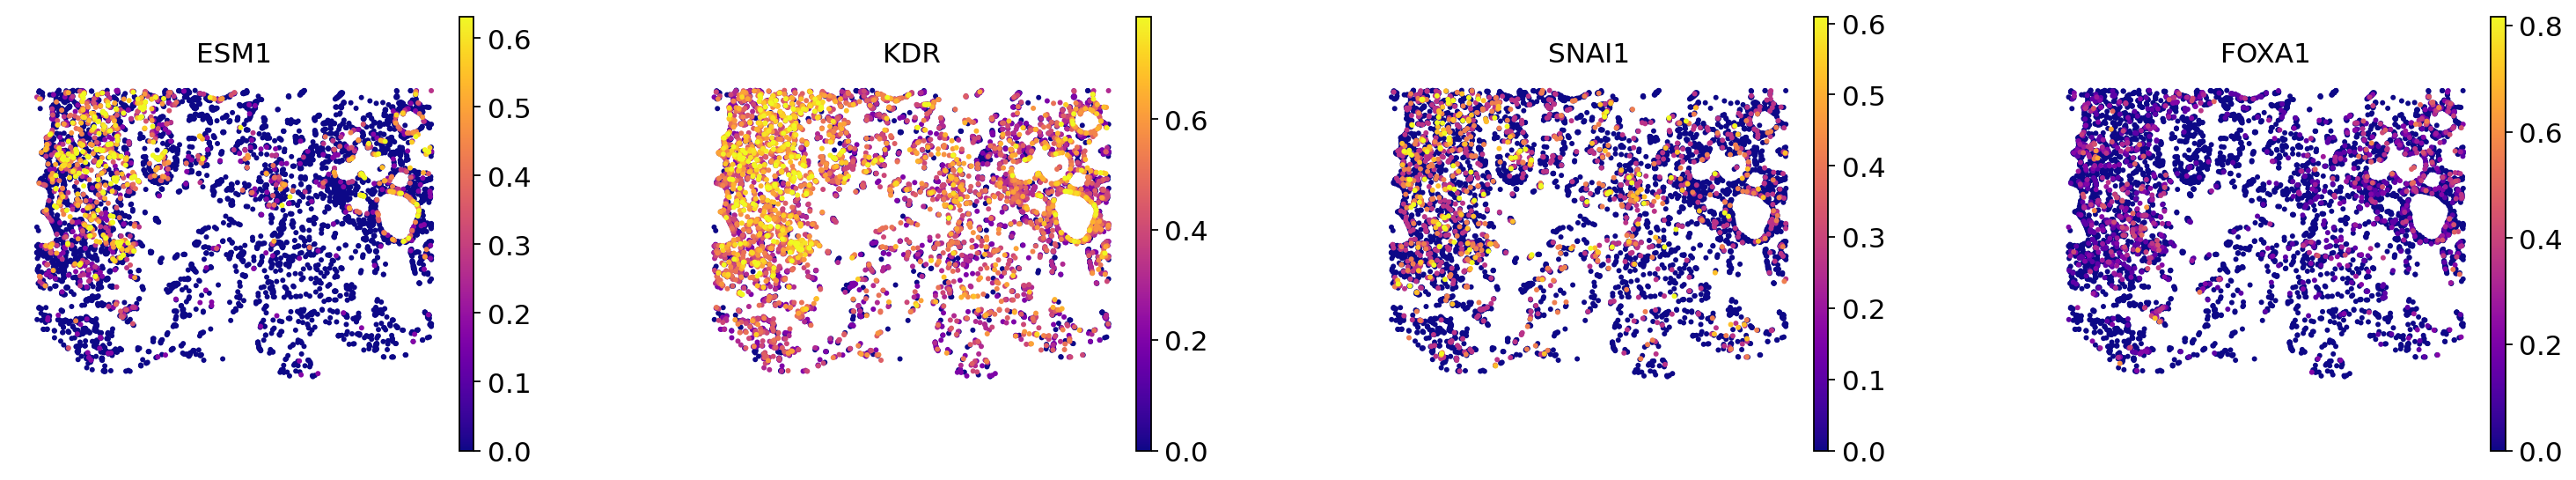

In [38]:
plot_endo = True

sc.pl.spatial(
    adata=adata_endothelial if plot_endo else adata_not_endo,
    spot_size=100 if plot_endo else 40,
    color=gene_list_invasive,
    frameon=False,
    use_raw=False,
    wspace=0.4,
    vmax=percentiles_invasive,
    layer="min_max_scaled",
    cmap="plasma",
)

Then in all cells but endothelial:

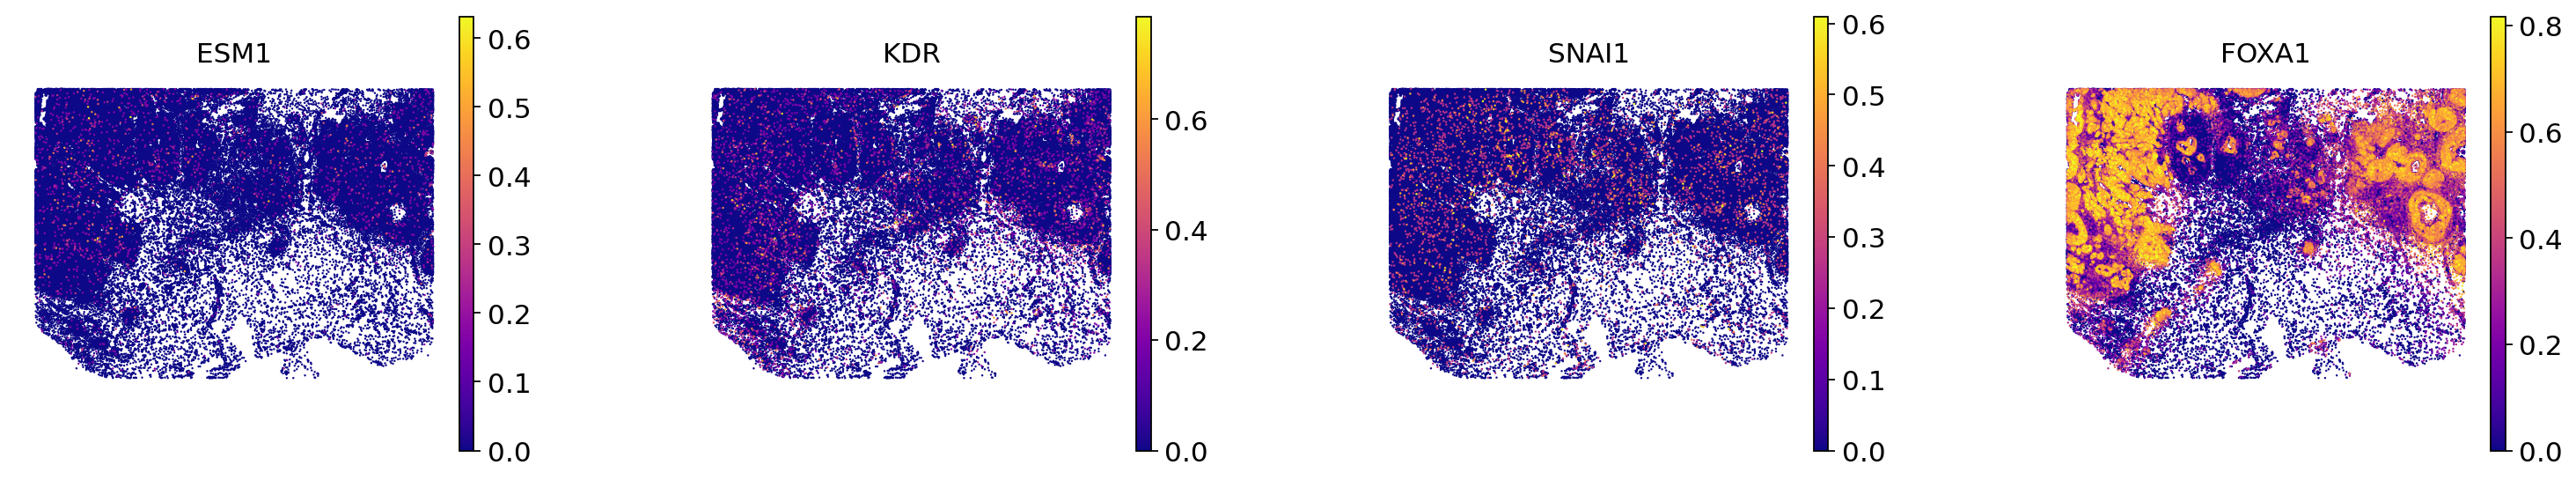

In [39]:
plot_endo = False

sc.pl.spatial(
    adata=adata_endothelial if plot_endo else adata_not_endo,
    spot_size=100 if plot_endo else 40,
    color=gene_list_invasive,
    frameon=False,
    use_raw=False,
    wspace=0.4,
    vmax=percentiles_invasive,
    layer="min_max_scaled",
    cmap="plasma",
)